In [11]:
%load_ext autoreload
%autoreload 2

# Shower Temperature Beginner Reinforcement Learning Example

This script implements the Bellman equation to train a Q table and test it.

## Import the shower environment

In [12]:
from shower_environment import Shower
import numpy as np
import matplotlib.pyplot as plt

## Sanity checks on our shower environment

In [13]:
env = Shower()

print("Random valid temperature:", env.observation_space.sample())
print("Random valid temperature change:", env.action_space.sample()-1)

print("\nA few random showers:")
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        #env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print(f"Episode: {episode} Score: {score}")

Random valid temperature: 58
Random valid temperature change: 1

A few random showers:
Episode: 1 Score: 24
Episode: 2 Score: -38
Episode: 3 Score: -60
Episode: 4 Score: -60
Episode: 5 Score: -52


## Update q table function
* Based on initial and final states
* the action that took us from initial to final, 
* and the reward assigned to the action/final state

In [14]:
def update_q_table(params, q_table, state_i, state_f, action, step_reward):
    try:
        # note about 2d np array access:
        # q_table[state_i] accesses the state_i-th row, which is an array with
        # length equal to number of actions.
        # q_table[state_i, action] access the action-th element of the state_ith
        # array.
        old_q_value = q_table[state_i, action]
    except IndexError:
        print("ERROR with q_table")
        print(q_table)
        print(state_i, action)
        return None
    
    # max q value given the state after this temp change
    next_max = np.max(q_table[state_f])
    q_target = step_reward + params['gamma'] * next_max
    q_delta = q_target - old_q_value
    q_table[state_i, action] = old_q_value + params['alpha'] * q_delta
    
    return q_table

## Train and test function
Loop showers, update q table

In [15]:
# alpha - learning rate
# gamma - discount rate
# epsilon - exploration threshold (not currently used)
default_params = {'alpha' : 0.9, 'gamma' : 1., 'epsilon' : 0.}

In [16]:
# loop showers
def train_test(env, in_q_table, n_episodes = 200, do_train = True, params = default_params):
    q_table = in_q_table.copy()
    total_reward = 0
    for i_shower in range(n_episodes):
        done = False
        env.reset()
        state_i = env.state
        shower_reward = 0
        #print(i_shower)
        while not done:
            # choose action
            action = env.action_space.sample() if do_train else np.argmax(q_table[state_i])

            # take a step
            state_f, reward, done, info = env.step(action)
            #print("  ", env.shower_time, state, reward, done)
            try:
                assert state_f in env.observation_space
            except AssertionError:
                print("Invalid state obtained", state_f, i_shower, env.shower_time, action)
                break
                                        
            # update q table
            if do_train:
                q_table = update_q_table(params, q_table, state_i, state_f, action, reward)

            # increment reward
            shower_reward += reward

            state_i = state_f
            
        #print("  Shower reward:", shower_reward)
        total_reward += shower_reward

    #np.savetxt("qtable.csv", q_table, delimiter=",")
    avg_reward = total_reward / n_episodes
    return q_table, avg_reward

## Train

In [17]:
init_q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [18]:
env = Shower()
q_table, avg_reward = train_test(env, init_q_table, n_episodes = 2, do_train = True)
print(f"average reward: {avg_reward}")

average reward: -17.0


## Test

In [19]:
avg_reward = train_test(env, q_table, n_episodes = 100, do_train = False)[1]
print(f"average reward: {avg_reward}")
avg_reward = train_test(env, q_table, n_episodes = 100, do_train = False)[1]
print(f"average reward: {avg_reward}")
avg_reward = train_test(env, q_table, n_episodes = 100, do_train = False)[1]
print(f"average reward: {avg_reward}")

average reward: 19.34
average reward: 20.46
average reward: 21.96


# Visualize and optimize some parameters

### rewards as a function of training episodes

In [20]:
episodes = range(2,100,2)
rewards = []
for e in episodes:
    env = Shower()
    q_table = train_test(env, init_q_table, n_episodes = e, do_train = True)[0]
    avg_reward = train_test(env, q_table, n_episodes = 100, do_train = False)[1]
    if e % 10 == 0: 
        print(f"{e} training episodes – average reward: {avg_reward}")
    rewards.append(avg_reward)

10 training episodes – average reward: 29.1
20 training episodes – average reward: 51.64
30 training episodes – average reward: 54.82
40 training episodes – average reward: 54.9
50 training episodes – average reward: 54.5
60 training episodes – average reward: 54.18
70 training episodes – average reward: 55.16
80 training episodes – average reward: 53.78
90 training episodes – average reward: 54.92


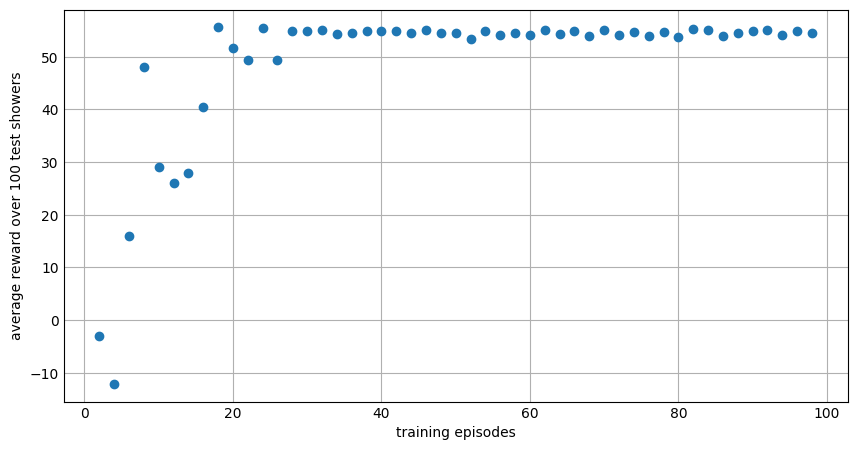

In [21]:
plt.style.use('_mpl-gallery')

fig, ax = plt.subplots(figsize=(8,4))

ax.scatter(episodes, rewards)

plt.ylabel('average reward over 100 test showers')
plt.xlabel('training episodes')

plt.show()

## Grid search for best learning and discount rates

In [36]:
from sklearn.model_selection import ParameterGrid
from collections import defaultdict

In [238]:
# 20x10x10 = 2000 trainings, many of them short
param_grid = ParameterGrid({'alpha': np.arange(0., 1., 0.1).tolist(), 
                            'gamma': np.arange(0., 1., 0.1).tolist(), 
                            'n_episodes' : range(10,100,10)})
alphas = defaultdict(list)
gammas = defaultdict(list)
rewards = defaultdict(list)
for p in list(param_grid):
    env = Shower()
    q_table = train_test(env, init_q_table, n_episodes = p['n_episodes'], do_train = True, params=p)[0]
    avg_reward = train_test(env, q_table, n_episodes = 100, do_train = False)[1]
    alphas[p['n_episodes']].append(p['alpha'])
    gammas[p['n_episodes']].append(p['gamma'])
    rewards[p['n_episodes']].append(avg_reward)        
    #print(f"{e} training episodes – average reward: {avg_reward}")

### plot rewards vs parameters
#### with a slidebar for the number of trainings

In [232]:
import math
from ipywidgets import interact,widgets

In [297]:
def plot_hyperparams_grid(n_episodes, data_x, data_y, data_z):
    f, ax = plt.subplots(figsize=(8,6))
    
    graph_x = data_x[n_episodes]
    graph_y = data_y[n_episodes]
    graph_z = data_z[n_episodes]
    
    # marker sizes - 1 invisible, 10 very small, 100 small, 5000 very big,  
    size_list=np.array(graph_z)
    size_list = [5e-12*(i+60)**7 for i in size_list]
    
    points=ax.scatter(graph_x, graph_y, c=graph_z, cmap='viridis',vmin=0,vmax=60,marker='o',s=size_list)
    cbar=plt.colorbar(points)
    cbar.set_label("Rewards", fontsize=14)
    ax.set_xlabel(r'$\alpha$ - learning rate',fontsize=14)
    ax.set_ylabel(r'$\gamma$ - discount rate',fontsize=14)
    ax.set_yticks(np.arange(0,1,.1))
    ax.set_xticks(np.arange(0,1,.1))
    ax.set_title(f"Parameter space at {n_episodes} training episodes")
    plt.show()

interact(
        plot_hyperparams_grid,
        n_episodes = widgets.SelectionSlider(description='train length', options = list(alphas.keys())), 
        data_x = fixed(alphas), 
        data_y = fixed(gammas),
        data_z = fixed(rewards)
        );

interactive(children=(SelectionSlider(description='train length', options=(10, 20, 30, 40, 50, 60, 70, 80, 90)…

### and the max values

In [339]:
print("n_training episodes | max reward | alpha | gamma")
for training, reward in rewards.items():
    max_reward = max(reward)
    alpha = alphas[training][reward.index(max(reward))]
    gamma = gammas[training][reward.index(max(reward))]
    print(f'{training:19} | {max_reward:10.2f} | {alpha:5.1f} | {gamma:5.1f}')

n_training episodes | max reward | alpha | gamma
                 10 |      43.50 |   0.6 |   0.7
                 20 |      54.76 |   0.8 |   0.9
                 30 |      55.78 |   0.6 |   0.9
                 40 |      55.64 |   0.7 |   0.9
                 50 |      55.16 |   0.4 |   0.9
                 60 |      55.76 |   0.8 |   0.2
                 70 |      55.22 |   0.7 |   0.6
                 80 |      55.78 |   0.7 |   0.9
                 90 |      55.84 |   0.5 |   0.3


#### Seems like some of these are statistical flukes.  alpha, gamma = 1,1 clearly performs best across all n_trainings